<a href="https://colab.research.google.com/github/EstebanHernandezCapel/TFE/blob/main/Experiments/load_kappa_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [1]:
# -*- coding: utf-8 -*-

import math
import os
import json
import pickle
import random
from math import sqrt
from functools import reduce
# import wandb

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.benchmark import timer
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

!pip install numpyencoder
from numpyencoder import NumpyEncoder

import datetime
from joblib import dump, load
import joblib


from google.colab import drive
drive.mount('/content/drive')

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


# Loading and data Utility function

In [9]:
def periods_where_pv_is_null(df_inputs:pd.DataFrame):
    """
    Compute the time periods where the PV generation is always 0 for the solar track.
    :param df_inputs: solar track data.
    :return: indices where PV is always 0.
    """
    # Determine time periods where PV generation is 0
    nb_days = int(df_inputs[df_inputs['ZONE_1'] == 1]['POWER'].shape[0] / 24)
    max_zone1 = df_inputs[df_inputs['ZONE_1'] == 1]['POWER'].values.reshape(nb_days, 24).max(axis=0)
    max_zone2 = df_inputs[df_inputs['ZONE_2'] == 1]['POWER'].values.reshape(nb_days, 24).max(axis=0)
    max_zone3 = df_inputs[df_inputs['ZONE_3'] == 1]['POWER'].values.reshape(nb_days, 24).max(axis=0)

    indices1 = np.where(max_zone1 == 0)[0]
    indices2 = np.where(max_zone2 == 0)[0]
    indices3 = np.where(max_zone3 == 0)[0]

    print('zone 1', indices1)
    print('zone 2', indices2)
    print('zone 3', indices3)

    return indices1

def wind_data(path_name: str, random_state: int = 0, test_size:int=2*12*2):
    """
    Build the wind power data for the GEFcom IJF_paper case study.
    """

    df_wind = pd.read_csv(path_name, parse_dates=True, index_col=0)
    ZONES = ['ZONE_' + str(i) for i in range(1, 10 + 1)]

    # INPUTS DESCRIPTION
    # The predictors included wind forecasts at two heights, 10 and 100 m above ground level, obtained from the European Centre for Medium-range Weather Forecasts (ECMWF).
    # These forecasts were for the zonal and meridional wind components (denoted u and v), i.e., projections of the wind vector on the west-east and south-north axes, respectively.

    # U10 zonal wind component at 10 m
    # V10 meridional wind component at 10 m
    # U100 zonal wind component at 100 m
    # V100 meridional wind component at 100 m

    # ------------------------------------------------------------------------------------------------------------------
    # Build derived features
    # cf winner GEFcom2014 wind track “Probabilistic gradient boosting machines for GEFCom2014 wind forecasting”
    # ------------------------------------------------------------------------------------------------------------------

    # the wind speed (ws), wind energy (we), and wind direction (wd) were as follows,
    # where u and v are the wind components provided and d is the density, for which we used a constant 1.0
    # ws = sqrt[u**2  + v**2]
    # we = 0.5 × d × ws**3
    # wd = 180/π × arctan(u, v)

    df_wind['ws10'] = np.sqrt(df_wind['U10'].values ** 2 + df_wind['V10'].values ** 2)
    df_wind['ws100'] = np.sqrt(df_wind['U100'].values ** 2 + df_wind['V100'].values ** 2)
    df_wind['we10'] = 0.5 * 1 * df_wind['ws10'].values ** 3
    df_wind['we100'] = 0.5 * 1 * df_wind['ws100'].values ** 3
    df_wind['wd10'] = np.arctan2(df_wind['U10'].values, df_wind['V10'].values) * 180 / np.pi
    df_wind['wd100'] = np.arctan2(df_wind['U100'].values, df_wind['V100'].values) * 180 / np.pi

    features = ['U10', 'V10', 'U100', 'V100', 'ws10', 'ws100', 'we10', 'we100', 'wd10', 'wd100']

    data_zone = []
    for zone in ZONES:
        df_var = df_wind[df_wind[zone] == 1].copy()
        nb_days = int(len(df_var) / 24)
        zones = [df_var[zone].values.reshape(nb_days, 24)[:, 0].reshape(nb_days, 1) for zone in ZONES]
        x = np.concatenate([df_var[col].values.reshape(nb_days, 24) for col in features] + zones, axis=1)
        y = df_var['TARGETVAR'].values.reshape(nb_days, 24)
        df_y = pd.DataFrame(data=y, index=df_var['TARGETVAR'].asfreq('D').index)
        df_x = pd.DataFrame(data=x, index=df_var['TARGETVAR'].asfreq('D').index)

        # Decomposition between LS, VS & TEST sets (TRAIN = LS + VS)
        df_x_train, df_x_TEST, df_y_train, df_y_TEST = train_test_split(df_x, df_y, test_size=test_size,random_state=random_state, shuffle=True)
        df_x_LS, df_x_VS, df_y_LS, df_y_VS = train_test_split(df_x_train, df_y_train, test_size=test_size,random_state=random_state, shuffle=True)

        data_zone.append([df_x_LS, df_y_LS, df_x_VS, df_y_VS, df_x_TEST, df_y_TEST])

        nb_days_LS = len(df_y_LS)
        nb_days_VS = len(df_y_VS)
        nb_days_TEST = len(df_y_TEST)
        print('#LS %s days #VS %s days # TEST %s days' % (nb_days_LS, nb_days_VS, nb_days_TEST))

    return [pd.concat([data_zone[i][j] for i in range(0, 9 + 1)], axis=0, join='inner') for j in range(0, 5 + 1)]


def load_data(path_name: str, random_state: int = 0, test_size:int=2*12*2):
    """
    Build the load power data for the GEFcom IJF_paper case study.
    """
    df_load = pd.read_csv(path_name, parse_dates=True, index_col=0)
    features = ['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10',
                'w11', 'w12', 'w13', 'w14', 'w15', 'w16', 'w17', 'w18', 'w19', 'w20',
                'w21', 'w22', 'w23', 'w24', 'w25']
    max_load = df_load['LOAD'].max()

    nb_days = int(len(df_load) / 24)
    x = np.concatenate([df_load[col].values.reshape(nb_days, 24) for col in features], axis=1)
    y = df_load['LOAD'].values.reshape(nb_days, 24) / max_load
    df_y = pd.DataFrame(data=y, index=df_load['LOAD'].asfreq('D').index)
    df_x = pd.DataFrame(data=x, index=df_load['LOAD'].asfreq('D').index)

    # Decomposition between LS, VS & TEST sets (TRAIN = LS + VS)
    df_x_train, df_x_TEST, df_y_train, df_y_TEST = train_test_split(df_x, df_y, test_size=test_size,
                                                                    random_state=random_state, shuffle=True)
    df_x_LS, df_x_VS, df_y_LS, df_y_VS = train_test_split(df_x_train, df_y_train, test_size=test_size,
                                                          random_state=random_state, shuffle=True)

    nb_days_LS = len(df_y_LS)
    nb_days_VS = len(df_y_VS)
    nb_days_TEST = len(df_y_TEST)
    print('#LS %s days #VS %s days # TEST %s days' % (nb_days_LS, nb_days_VS, nb_days_TEST))

    return df_x_LS, df_y_LS, df_x_VS, df_y_VS, df_x_TEST, df_y_TEST


def build_pv_features(df_var:pd.DataFrame, indices:np.array):
    """
    Build features for NFs multi-output.
    :param df_var: (n_periods, n_features)
    :param indices: index where PV generation is always 0.
    # INPUTS DESCRIPTION
    # Variable id. Variable name
    # 078.128 Total column liquid water (tclw)
    # 079.128 Total column ice water (tciw)
    # 134.128 Surface pressure (SP)
    # 157.128 Relative humidity at 1000 mbar (r)
    # 164.128 Total cloud cover (TCC)
    # 165.128 10-metre U wind component (10u)
    # 166.128 10-metre V wind component (10v)
    # 167.128 2-metre temperature (2T)
    # 169.128 Surface solar rad down (SSRD)
    # 175.128 Surface thermal rad down (STRD)
    # 178.128 Top net solar rad (TSR)
    # 228.128 Total precipitation (TP)
    """
    n_days = int(len(df_var) / 24)  # n days

    # Reshaping features from (24 * n_days,) to (n_days, 24) then drop time periods where PV is always 0
    y = df_var['POWER'].values.reshape(n_days, 24)
    y = np.delete(y, indices, axis=1)

    tclw = df_var['VAR78'].values.reshape(n_days, 24)
    tclw = np.delete(tclw, indices, axis=1)
    tciw = df_var['VAR79'].values.reshape(n_days, 24)
    tciw = np.delete(tciw, indices, axis=1)
    sp = df_var['VAR134'].values.reshape(n_days, 24)
    sp = np.delete(sp, indices, axis=1)
    rh = df_var['VAR157'].values.reshape(n_days, 24)
    rh = np.delete(rh, indices, axis=1)
    TCC = df_var['VAR164'].values.reshape(n_days, 24)
    TCC = np.delete(TCC, indices, axis=1)
    windU = df_var['VAR165'].values.reshape(n_days, 24)
    windU = np.delete(windU, indices, axis=1)
    windV = df_var['VAR166'].values.reshape(n_days, 24)
    windV = np.delete(windV, indices, axis=1)
    TT = df_var['VAR167'].values.reshape(n_days, 24)
    TT = np.delete(TT, indices, axis=1)
    SSRD = df_var['VAR169'].values.reshape(n_days, 24)
    SSRD = np.delete(SSRD, indices, axis=1)
    STRD = df_var['VAR175'].values.reshape(n_days, 24)
    STRD = np.delete(STRD, indices, axis=1)
    TSR = df_var['VAR178'].values.reshape(n_days, 24)
    TSR = np.delete(TSR, indices, axis=1)
    TP = df_var['VAR228'].values.reshape(n_days, 24)
    TP = np.delete(TP, indices, axis=1)
    zone1 = df_var['ZONE_1'].values.reshape(n_days, 24)[:, 0].reshape(n_days, 1)
    zone2 = df_var['ZONE_2'].values.reshape(n_days, 24)[:, 0].reshape(n_days, 1)
    zone3 = df_var['ZONE_3'].values.reshape(n_days, 24)[:, 0].reshape(n_days, 1)

    x = np.concatenate([TT, SSRD, np.multiply(SSRD, SSRD), np.multiply(SSRD, TT), rh, zone1, zone2, zone3], axis=1)

    return x,y

def pv_data(path_name: str, test_size:int, random_state:int=0):
    """
    Build the PV data for the GEFcom IJF_paper case study.
    """

    df_pv = pd.read_csv(path_name, parse_dates=True, index_col=0)

    ZONES = ['ZONE_1', 'ZONE_2', 'ZONE_3']
    indices = periods_where_pv_is_null(df_inputs=df_pv)

    data_zone = []
    for zone in ZONES:
        df_var = df_pv[df_pv[zone] == 1].copy()
        d_index = df_var['POWER'].asfreq('D').index
        x, y = build_pv_features(df_var=df_var, indices=indices)

        df_y = pd.DataFrame(data=y, index=d_index)
        df_x = pd.DataFrame(data=x, index=d_index)

        # Decomposition between LS, VS & TEST sets (TRAIN = LS + VS)
        df_x_train, df_x_TEST, df_y_train, df_y_TEST = train_test_split(df_x, df_y, test_size=test_size, random_state=random_state, shuffle=True)
        df_x_LS, df_x_VS, df_y_LS, df_y_VS = train_test_split(df_x_train, df_y_train, test_size=test_size, random_state=random_state, shuffle=True)

        data_zone.append([df_x_LS, df_y_LS, df_x_VS, df_y_VS, df_x_TEST, df_y_TEST])

        nb_days_LS = len(df_y_LS)
        nb_days_VS = len(df_y_VS)
        nb_days_TEST = len(df_y_TEST)
        print('%s #LS %s days #VS %s days # TEST %s days' % (zone, nb_days_LS, nb_days_VS, nb_days_TEST))

    return [pd.concat([data_zone[i][j] for i in [0, 1, 2]], axis=0, join='inner') for j in range(0, 5 + 1)], indices


def scale_data_multi(x_LS: np.array, y_LS: np.array, x_VS: np.array, y_VS: np.array, x_TEST: np.array, y_TEST: np.array):
    """
    Scale data for NFs multi-output.
    """
    y_LS_scaler = StandardScaler()
    y_LS_scaler.fit(y_LS)
    y_LS_scaled = y_LS_scaler.transform(y_LS)
    y_VS_scaled = y_LS_scaler.transform(y_VS)
    y_TEST_scaled = y_LS_scaler.transform(y_TEST)

    x_LS_scaler = StandardScaler()
    x_LS_scaler.fit(x_LS)
    x_LS_scaled = x_LS_scaler.transform(x_LS)
    x_VS_scaled = x_LS_scaler.transform(x_VS)
    x_TEST_scaled = x_LS_scaler.transform(x_TEST)

    return x_LS_scaled, y_LS_scaled,  x_VS_scaled, y_VS_scaled, x_TEST_scaled, y_TEST_scaled, y_LS_scaler

#Setup the data

In [29]:
# Set the working directory to the root of the project
print(os.getcwd())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

# ------------------------------------------------------------------------------------------------------------------
# GEFcom IJF_paper case study
# Solar track: 3 zones
# Wind track: 10 zones
# Load track: 1 zones
# 50 days picked randomly per zone for the VS and TEST sets

# Decribe the model here
# ------------------------------------------------------------------------------------------------------------------

tag = 'load'  # pv, wind, load
gpu = True  # put False to use CPU
print('Using gpu: %s ' % torch.cuda.is_available())
if gpu:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dir_path = 'export/diff_' + tag + '/'
if not os.path.isdir(dir_path):  # test if directory exist
    os.makedirs(dir_path)

# ------------------------------------------------------------------------------------------------------------------
# Built the LS, VS, and TEST sets
# ------------------------------------------------------------------------------------------------------------------

if tag == 'pv':
    # WARNING: the time periods where PV is always 0 (night hours) are removed -> there are 8 periods removed
    # The index of the time periods removed are provided into indices
    data, indices = pv_data(path_name='/content/drive/MyDrive/TFE/data/solar_new.csv', test_size=50, random_state=0)
    ylim_loss = [0, 15]
    ymax_plf = 2.5
    ylim_crps = [0, 12]
    nb_zones = 3

elif tag == 'wind':
    data = wind_data(path_name='/content/drive/MyDrive/TFE/data/wind_data_all_zone.csv', test_size=50, random_state=0)
    ylim_loss = [0, 30]
    ymax_plf = 8
    ylim_crps = [6, 12]
    nb_zones = 10
    indices = []

elif tag == 'load':
    data = load_data(path_name= '/content/drive/MyDrive/TFE/data/load_data_track1.csv', test_size=50, random_state=0)
    ylim_loss = [-5, 10]
    ymax_plf = 2
    ylim_crps = [0, 5]
    nb_zones = 1
    indices = []

# reduce the LS size from 634 days to D days
df_x_LS = data[0].copy()
df_y_LS = data[1].copy()
df_x_VS = data[2].copy()
df_y_VS = data[3].copy()
df_x_TEST = data[4].copy()
df_y_TEST = data[5].copy()

nb_days_LS = len(df_y_LS)
nb_days_VS = len(df_y_VS)
nb_days_TEST = len(df_y_TEST)

ls_size = len(df_y_LS)
vs_size = len(df_y_VS)
test_size = len(df_y_TEST)

print('#LS %s days #VS %s days # TEST %s days' % (nb_days_LS / nb_zones, nb_days_VS / nb_zones, nb_days_TEST / nb_zones))

# ------------------------------------------------------------------------------------------------------------------
# Scale the LS, VS, and TEST sets
# ------------------------------------------------------------------------------------------------------------------

# WARNING: use the scaler fitted on the TRAIN LS SET !!!!
x_LS_scaled, y_LS_scaled, x_VS_scaled, y_VS_scaled, x_TEST_scaled, y_TEST_scaled, y_LS_scaler = scale_data_multi(x_LS=df_x_LS.values, y_LS=df_y_LS.values, x_VS=df_x_VS.values, y_VS=df_y_VS.values, x_TEST=df_x_TEST.values, y_TEST=df_y_TEST.values)

print(tag)

/content
Using gpu: False 
Using gpu: False 
#LS 1999 days #VS 50 days # TEST 50 days
#LS 1999.0 days #VS 50.0 days # TEST 50.0 days
load


#Energy score

In [30]:
def energy_score(s: np.array, y_true: np.array):
    """
    Compute the Energy score (ES).
    :param s: scenarios of shape (24*n_days, n_s)
    :param y_true: observations of shape = (n_days, 24)
    :return: the ES per day of the testing set.
    """

    print("###########")
    print(s.shape)
    print(y_true.shape)
    n_periods = y_true.shape[1]
    n_d = len(y_true)  # number of days
    n_s = s.shape[1]  # number of scenarios per day
    es = []
    # loop on all days
    for d in range(n_d):
        # select a day for both the scenarios and observations
        s_d = s[n_periods * d:n_periods * (d + 1), :]
        y_d = y_true[d, :]

        # compute the part of the ES
        simple_sum = np.mean([np.linalg.norm(s_d[:, s] - y_d) for s in range(n_s)])

        # compute the second part of the ES
        double_somme = 0
        for i in range(n_s):
            for j in range(n_s):
                double_somme += np.linalg.norm(s_d[:, i] - s_d[:, j])
        double_sum = double_somme / (2 * n_s * n_s)

        # ES per day
        es_d = simple_sum - double_sum
        es.append(es_d)
    return es

#Variogram

In [31]:
def variogram_score(s: np.array, y_true: np.array, beta: float):
    """
    Compute the Variogram score (VS).
    :param s: scenarios of shape (24*n_days, n_s)
    :param y_true: observations of shape = (n_days, 24)
    :param beta: order of the VS
    :return: the VS per day of the testing set.
    """
    
    print("###########")
    print(s.shape)
    print(y_true.shape)

    n_periods = y_true.shape[1]
    n_d = len(y_true)  # number of days
    n_s = s.shape[1]  # number of scenarios per day
    weights = 1  # equal weights across all hours of the day
    vs = []
    # loop on all days
    for d in range(n_d):
        # select a day for both the scenarios and observations
        s_d = s[n_periods * d:n_periods * (d + 1), :]
        y_d = y_true[d, :]

        # Double loop on time periods of the day
        vs_d = 0
        for k1 in range(n_periods):
            for k2 in range(n_periods):
                # VS first part
                first_part = np.abs(y_d[k1] - y_d[k2]) ** beta
                second_part = 0
                # Loop on all scenarios to compute VS second part
                for i in range(n_s):
                    second_part += np.abs(s_d[k1, i] - s_d[k2, i]) ** beta
                second_part = second_part / n_s
                vs_d += weights * (first_part - second_part) ** 2
        # VS per day
        vs.append(vs_d)
    return vs

# Quantiles and marginals metrics

In [32]:
def crps_nrg_marginal(y_true:float, y_sampled:np.array):
    """
    Compute the CRPS NRG for a given time period k -> the CRPS is a univariate metric.
    Therefore it has to be computed per marginal.
    :param y_true: true value for this time period.
    :param y_sampled: nb quantile/scenarios for time period k with shape(nb,)
    """
    nb = y_sampled.shape[0] # Nb of quantiles/scenarios sampled.
    simple_sum = np.sum(np.abs(y_sampled - y_true)) / nb
    double_somme = 0
    for i in range(nb):
        for j in range(nb):
            double_somme += np.abs(y_sampled[i] - y_sampled[j])
    double_sum = double_somme / (2 * nb * nb)

    crps = simple_sum  - double_sum

    return crps

def plf_per_quantile(quantiles:np.array, y_true:np.array):
    """
    Compute PLF per quantile.
    :param quantiles: (nb_periods, nb_quantiles)
    :param y_true:  (nb_periods,)
    :return: PLF per quantile into an array (nb_quantiles, )
    """
    # quantile q from 0 to N_q -> add 1 to be from 1 to N_q into the PLF score
    N_q = quantiles.shape[1]
    plf = []
    for q in range(0 ,N_q):
        # for a given quantile compute the PLF over the entire dataset
        diff = y_true - quantiles[:,q]
        plf_q = sum(diff[diff >= 0] * ((q+1) / (N_q+1))) / len(diff) + sum(-diff[diff < 0] * (1 - (q+1) / (N_q+1))) / len(diff) # q from 0 to N_q-1 -> add 1 to be from 1 to N_q
        plf.append(plf_q)
    return 100 * np.asarray(plf)

def plot_plf_per_quantile(plf_VS: np.array, plf_TEST: np.array, dir_path: str, name: str, ymax:float=None):
    """
    Plot the quantile score (PLF = Pinball Loss Function) per quantile on the VS & TEST sets.
    """
    FONTSIZE = 10
    plt.figure()
    plt.plot([q for q in range(1, len(plf_VS) + 1)], plf_TEST, 'b')
    plt.hlines(y=plf_TEST.mean(), colors='b', xmin=1, xmax=len(plf_VS),  label='TEST av ' + str(round(plf_TEST.mean(), 4)))
    plt.plot([q for q in range(1, len(plf_VS) + 1)], plf_VS, 'g')
    plt.hlines(y=plf_VS.mean(), colors='g', xmin=1, xmax=len(plf_VS), label='VS av ' + str(round(plf_VS.mean(), 4)))
    if ymax:
        plt.ylim(0, ymax)
        plt.vlines(x=(len(plf_VS) + 1) / 2, colors='k', ymin=0, ymax=ymax)
    else:
        plt.ylim(0, max(plf_TEST.max(), plf_VS.max()))
        plt.vlines(x=(len(plf_VS) + 1) / 2, colors='k', ymin=0, ymax=max(plf_TEST.max(), plf_VS.max()))
    plt.xlim(0, len(plf_VS) + 1)
    plt.tick_params(axis='both', labelsize=FONTSIZE)
    plt.xlabel('q', fontsize=FONTSIZE)
    plt.ylabel('%', fontsize=FONTSIZE)
    plt.legend(fontsize=FONTSIZE)
    plt.title(name)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(dir_path + name + '.pdf')
    plt.show()

def compare_plf(dir: str, plf: list, name: str, ylim:list, labels:str):
    """
    Plot the quantile score (PLF = Pinball Loss Function) per quantile on TEST sets of multiple generative models.
    :param plf: list of the plf_score of multiple generative models. Each element of the list is an array.
    """
    x_index = [q for q in range(1, len(plf[0]) + 1)]
    FONTSIZE = 10
    plt.figure()
    for l, label in zip(plf, labels):
        plt.plot(x_index, l, label=label)
    plt.ylim(ylim[0], ylim[1])
    plt.vlines(x=(len(plf[0])  + 1) / 2, colors='k', ymin=0, ymax=ylim[1])
    plt.xlim(0, len(plf[0])  + 1)
    plt.tick_params(axis='both', labelsize=FONTSIZE)
    plt.xlabel('$q$', fontsize=FONTSIZE)
    plt.ylabel('%', fontsize=FONTSIZE)
    plt.legend(fontsize=1.5*FONTSIZE)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(dir + name + '.pdf')
    plt.show()

def compute_reliability(y_true: np.array, y_quantile: np.array, tag: str = 'pv'):
    """
    Compute averaged reliability score per day over all quantiles.
    :param y_true: true values (n_periods, ).
    :param y_quantile: quantiles (n_periods, n_quantiles).
    :return: PLF array of shape (n_quantiles,)
    """
    nb_q = y_quantile[0].shape[0]

    aq = []
    if tag == 'pv':
        # WARNING REMOVE TIME PERIODS WHERE PV GENERATION IS 0 during night hours !!!!
        # indices where PV generation is 0 at day d
        indices = np.where(y_true == 0)[0]
        y_true = np.delete(y_true, indices).copy()
        y_quantile = np.delete(y_quantile, indices, axis=0).copy()

    nb_periods = len(y_true)
    for q in range(0, nb_q):
        aq.append(sum(y_true < y_quantile[:, q]) / nb_periods)

    return 100 * np.asarray(aq)


def reliability_diag(aq_VS: np.array, aq_TEST: np.array, dir_path: str, name: str):
    """
    Reliablity diagram per quantile on the VS & TEST sets.
    :param aq_VS:  (n_quantiles, ).
    :param aq_TEST:  (n_quantiles, ).
    """

    N_q = aq_VS.shape[0]
    q_set = [i / (N_q + 1) for i in range(1, N_q + 1)]

    FONTSIZE = 10
    x_index = np.array(q_set) * 100
    plt.figure()
    plt.plot(x_index, x_index, 'k')
    plt.plot(x_index, aq_TEST, 'b', label='TEST')
    plt.plot(x_index, aq_VS, 'g', label='VS')
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.xlabel('$q$', fontsize=FONTSIZE)
    plt.tick_params(axis='both', labelsize=FONTSIZE)
    plt.xticks(ticks=[i for i in range(0, 100 + 10, 10)])
    plt.yticks(ticks=[i for i in range(0, 100 + 10, 10)])
    plt.ylabel('%', fontsize=FONTSIZE)
    plt.title(name)
    plt.legend(fontsize=FONTSIZE)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(dir_path + name + '.pdf')
    plt.show()


def plot_multi_days_scenarios(quantiles: np.array, scenarios: np.array, y_true: np.array, dir_path: str, name: str, n_s: int,
                              ylim: float = 1):
    """
    Plot 4 days with subplots (2, 1).
    :param quantiles: (n_periods, n_s).
    :param scenarios: (n_periods, n_q).
    :param y_true: np.array with (n_periods, )
    """

    FONTSIZE = 10
    x_index = [i for i in range(1, 2 * 24 + 1)]
    fig, axs = plt.subplots(2, 1, sharex='col', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0})
    axs[0].plot(x_index, scenarios[:2 * 24, :n_s], color='gray', linewidth=1, alpha=0.5)
    axs[0].plot(x_index, quantiles[:2 * 24, 9], color='b', linewidth=2, label='10 %')
    axs[0].plot(x_index, quantiles[:2 * 24, 49], color='k', linewidth=2, label='50 %')
    axs[0].plot(x_index, quantiles[:2 * 24, 89], color='g', linewidth=2, label='90 %')
    axs[0].plot(x_index, y_true[:2 * 24], color='r', linewidth=2, label='obs')
    axs[0].set_ylim(0, ylim)
    axs[0].tick_params(axis='both', labelsize=FONTSIZE)

    axs[1].plot(x_index, scenarios[2 * 24:4 * 24, :n_s], color='gray', linewidth=1, alpha=0.5)
    axs[1].plot(x_index, quantiles[2 * 24:4 * 24, 9], color='b', linewidth=2, label='10 %')
    axs[1].plot(x_index, quantiles[2 * 24:4 * 24, 49], color='k', linewidth=2, label='50 %')
    axs[1].plot(x_index, quantiles[2 * 24:4 * 24, 89], color='g', linewidth=2, label='90 %')
    axs[1].plot(x_index, y_true[2 * 24:4 * 24], color='r', linewidth=2, label='obs')
    axs[1].set_ylim(0, ylim)
    axs[1].tick_params(axis='both', labelsize=FONTSIZE)

    for ax in axs.flat:
        ax.label_outer()
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines[:4], labels[:4], fontsize=FONTSIZE, loc='center right', borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(dir_path + name + '.pdf')
    plt.show()

def plot_scenarios(quantiles: np.array, scenarios: np.array, y_true: np.array, dir_path: str, name: str, n_s: int, n_days:int=1, ylim:list=[0, 1]):
    """
    Plot n_days days in one plot consecutively.
    :param quantiles: (n_periods, n_s).
    :param scenarios: (n_periods, n_q).
    :param y_true: np.array with (n_periods, )
    """
    FONTSIZE = 15
    x_index = [i for i in range(1, n_days * 24 + 1)]
    plt.figure()
    plt.plot(x_index, scenarios[:n_days * 24, :n_s], color='gray', linewidth=1, alpha=0.5)
    plt.plot(x_index, quantiles[:n_days * 24, 9], color='b', linewidth=2, label='10 %')
    plt.plot(x_index, quantiles[:n_days * 24, 49], color='k', linewidth=2, label='50 %')
    plt.plot(x_index, quantiles[:n_days * 24, 89], color='g', linewidth=2, label='90 %')
    plt.plot(x_index, y_true[:n_days * 24], color='r', linewidth=2, label='obs')
    plt.ylim(ylim[0], ylim[1])
    plt.tick_params(axis='both', labelsize=FONTSIZE)
    legend = plt.legend(fontsize=1.5*FONTSIZE, loc='center right', borderaxespad=0.)
    legend.remove()
    plt.tight_layout()
    plt.savefig(dir_path + name + '.pdf')
    plt.show()


def crps_per_period(scenarios: np.array, y_true: np.array, max_s: int = 100):
    """
    Compute the CRPS per period or marginal. Indeed, the CRPS is a univariate score.
    :param scenarios: of shape (n_periods, n_s) with  n_periods = n_d * 24
    :param y_true: observations of shape (n_periods, ) with  n_periods = n_d * 24
    :return: averaged CRPS per time period CRPS into a np.array of shape (24,)
    """
    n_s = scenarios.shape[1]
    n_periods = scenarios.shape[0]
    n_d = int(len(y_true) / 24)
    # compute the CRPS with at most 100 scenarios otherwise take too much time and the difference over 100 is small
    n_s_max = min(n_s, max_s)

    # compute the CRPS over the entire TEST/VS set
    crps_t = np.asarray([crps_nrg_marginal(y_true=y_true[t], y_sampled=scenarios[t, :n_s_max]) for t in range(n_periods)])
    crps_averaged = crps_t.reshape(n_d, 24).mean(axis=0)  # averaged CRPS per time period (or by marginal)

    return crps_averaged, crps_t.reshape(n_d, 24)


def plot_crps_per_period(dir: str, name: str, crps_TEST: np.array, crps_VS: np.array, ylim: list, max_s: int):
    """
    :param crps_TEST: CRPS into a np.array of shape (24,)
    :param crps_VS: CRPS into a np.array of shape (24,)
    """
    TEST_av = 100 * crps_TEST.mean()
    VS_av = 100 * crps_VS.mean()

    FONTSIZE = 10
    plt.figure()
    plt.plot(100 * crps_TEST, 'b', label='TEST av = ' + str(round(TEST_av, 2)))
    plt.plot(100 * crps_VS, 'g', label='VS av = ' + str(round(VS_av, 2)))
    plt.hlines(y=TEST_av, xmin=0, xmax=23, colors='b')
    plt.hlines(y=VS_av, xmin=0, xmax=23, colors='g')
    plt.xticks(fontsize=FONTSIZE)
    plt.yticks(fontsize=FONTSIZE)
    plt.ylabel('%', fontsize=FONTSIZE)
    plt.legend(fontsize=FONTSIZE)
    plt.ylim(ylim[0], ylim[1])
    plt.tight_layout()
    plt.savefig(dir + name + '_crps_' + str(max_s) + '.pdf')
    plt.show()


def quantiles_and_evaluation(dir_path: str, s_VS: np.array, s_TEST: np.array, N_q: int, df_y_VS: pd.DataFrame,
                             df_y_TEST: pd.DataFrame, name: str, ymax_plf: float, ylim_crps: list, tag: str,
                             nb_zones: int):
    """
    Compute quantiles from scenarios.
    Compute metrics:
    - PLF
    - reliability diagrams
    - CRPS
    - plots of scenarios & quantiles
    #VS or #TEST = number of days of VS or TEST sets
    :param s_VS: array (#VS*24, n_s)
    :param s_TEST: array (#TEST*24, n_s)
    :param N_q: number of quantiles/percentiles.
    :param df_y_VS: VS true values into a pd.DataFrame with shape (#VS, 24)
    :param df_y_TEST: TEST true values into a pd.DataFrame with shape (#TEST, 24)
    :param name: name to export plots
    :param tag: pv, wind, load
    :param nb_zones: number of zones (PV 3, wind 10, load 1)
    """
    # --------------------------------------------------------------------------------------------------------------
    # 1. Generate quantiles from scenarios
    # --------------------------------------------------------------------------------------------------------------
    print("##### 1. Generate quantiles from scenarios ##### ")
    n_s = s_VS.shape[1]

    q_set = [i / (N_q + 1) for i in range(1, N_q + 1)]
    # Quantiles are generated into an array of shape (n_day*24, N_q)
    q_TEST = np.quantile(s_TEST, q=q_set, axis=1).transpose()
    q_VS = np.quantile(s_VS, q=q_set, axis=1).transpose()

    # --------------------------------------------------------------------------------------------------------------
    # 2. PLF TEST & VS
    # --------------------------------------------------------------------------------------------------------------
    print("##### 2. PLF TEST & VS #####")
    plf_TEST = plf_per_quantile(quantiles=q_TEST, y_true=df_y_TEST.values.reshape(-1))
    plf_VS = plf_per_quantile(quantiles=q_VS, y_true=df_y_VS.values.reshape(-1))
    print('PLF TEST %.4f VS %.4f' % (plf_TEST.mean(), plf_VS.mean()))
    print('')

    plot_plf_per_quantile(plf_VS=plf_VS, plf_TEST=plf_TEST, dir_path=dir_path, name='plf_' + name + '_' + str(n_s),
                          ymax=ymax_plf)

    # --------------------------------------------------------------------------------------------------------------
    # 3. Reliability diagram
    # --------------------------------------------------------------------------------------------------------------
    print("##### 3. Reliability diagram #####")
    nb_days_VS = len(df_y_VS)
    nb_days_TEST = len(df_y_TEST)

    aq_TEST = compute_reliability(y_true=df_y_TEST.values.reshape(-1), y_quantile=q_TEST, tag=tag)
    aq_VS = compute_reliability(y_true=df_y_VS.values.reshape(-1), y_quantile=q_VS, tag=tag)
    reliability_diag(aq_VS=aq_VS, aq_TEST=aq_TEST, dir_path=dir_path, name='reliability_' + name + '_' + str(n_s))

    mae_TEST = mean_absolute_error(y_true=np.array(q_set) * 100, y_pred=aq_TEST)
    mae_VS = mean_absolute_error(y_true=np.array(q_set) * 100, y_pred=aq_VS)
    rmse_TEST = math.sqrt(mean_squared_error(y_true=np.array(q_set) * 100, y_pred=aq_TEST))
    rmse_VS = math.sqrt(mean_squared_error(y_true=np.array(q_set) * 100, y_pred=aq_VS))
    print('MAE TEST %.2f VS %.2f' % (mae_TEST, mae_VS))
    print('RMSE TEST %.2f VS %.2f' % (rmse_TEST, rmse_VS))
    print('')

    # --------------------------------------------------------------------------------------------------------------
    # 4. PLOT 50 scenarios on the first 4 days of the TEST set over all the zones
    # --------------------------------------------------------------------------------------------------------------
    # print("##### 4. PLOT 50 scenarios on the first 4 days of the TEST set over all the zones #####")
    # nb_days_per_zone = int(nb_days_TEST / nb_zones)
    # # WARNING only for the first zone
    # for z in range(nb_zones):
    #     print("zone : ", z)
    #     plot_multi_days_scenarios(quantiles=q_TEST[24 * nb_days_per_zone * z:24 * nb_days_per_zone * (z + 1), :],
    #                               scenarios=s_TEST[24 * nb_days_per_zone * z:24 * nb_days_per_zone * (z + 1), :],
    #                               y_true=df_y_TEST.values.reshape(-1)[
    #                               24 * nb_days_per_zone * z:24 * nb_days_per_zone * (z + 1)], dir_path=dir_path,
    #                               name='TEST_zone_' + str(z) + '_' + name, n_s=50, ylim=1)
    # --------------------------------------------------------------------------------------------------------------
    # CRPS
    # --------------------------------------------------------------------------------------------------------------
    max_s = 100
    crps_TEST, crps_d_TEST = crps_per_period(scenarios=s_TEST, y_true=df_y_TEST.values.reshape(-1), max_s=max_s)
    crps_VS, crps_d_VS = crps_per_period(scenarios=s_VS, y_true=df_y_VS.values.reshape(-1), max_s=max_s)

    # print('CRPS TEST %.2f VS %.2f' % (100 * crps_TEST.mean(), 100 * crps_VS.mean()))
    # print('')

    # print('shapes: ' + str(crps_TEST.shape))
    # plot_crps_per_period(dir=dir_path, name=name, crps_TEST=crps_TEST, crps_VS=crps_VS, ylim=ylim_crps, max_s=max_s)

    return plf_TEST.mean(), mae_TEST, crps_TEST.mean()

def plot_corr_heat_map(dir: str, name: str, df_corr: pd.DataFrame, vlim: list):
    """
    Plot the correlation matrix with a heatmap
    cmap with _r = reverses the normal order of the color map 'RdYlGn'
    """
    FONTSIZE =15
    plt.figure()
    sns_plot = sns.heatmap(df_corr, cmap='RdYlGn_r', fmt=".1f", linewidths=0.5, xticklabels=False, yticklabels=False,
                           annot=False, vmin=vlim[0], vmax=vlim[1],cbar=False)
    sns_plot.set_yticklabels(sns_plot.get_yticklabels(), rotation='horizontal')
    cb = sns_plot.figure.colorbar(sns_plot.collections[0])  # Display colorbar
    cb.ax.tick_params(labelsize=FONTSIZE)  # Set the colorbar scale font size.
    plt.tight_layout()
    plt.savefig(dir + name + '_corr.pdf')
    plt.show()

def quality_comparison_per_track(dir_path: str, N_q: int, df_y: pd.DataFrame, name: str, ylim_plf: list, ylim_crps: list, tag: str, crps:bool=True):
    """
    Compare the generative models with quality scores:
    - PLF
    - reliability diagrams
    - CRPS
    - plots of scenarios & quantiles
    :param N_q: number of quantiles/percentiles.
    :param df_y: true values into a pd.DataFrame with shape (#TEST, 24) where #TEST = number of days of the TEST set
    :param name: name to export plots
    :param tag: pv, wind, load
    """
    nf_a_id = {'pv': 10,
               'wind': 8,
               'load': 1}
    nf_umnn_id = {'pv': 3,
               'wind': 1,
               'load': 1}

    y_true = df_y.values.reshape(-1) # reshape from (#TEST, 24) to (24*,#TEST)
    # --------------------------------------------------------------------------------------------------------------
    # 0. Load scenarios on the TS for 'NF-UMNN', 'NF-A', 'VAE', 'GAN', 'GC', 'RAND'
    # --------------------------------------------------------------------------------------------------------------
    labels = ['NF-UMNN', 'NF-A', 'VAE', 'GAN', 'GC', 'RAND']
    # scenarios shape = (24*n_days, n_s)
    s_umnn = read_file(dir='scenarios/nfs/', name='scenarios_' + tag + '_UMNN_M_' + str(nf_umnn_id[tag]) + '_0_100_TEST')
    s_an = read_file(dir='scenarios/nfs/', name='scenarios_' + tag + '_AN_M_' + str(nf_a_id[tag]) + '_0_100_TEST')
    s_vae = read_file(dir='scenarios/vae/', name='scenarios_' + tag + '_VAElinear_1_0_100_TEST')
    s_gan = read_file(dir='scenarios/gan/', name='scenarios_' + tag + '_GAN_wasserstein_1_0_100_TEST')
    s_gc = read_file(dir='scenarios/gc/', name='scenarios_' + tag + '_gc_100_TEST')
    s_rand = read_file(dir='scenarios/random/', name='scenarios_' + tag + '_random_100_TEST')
    scenarios_list = [s_umnn, s_an, s_vae, s_gan, s_gc, s_rand]

    # --------------------------------------------------------------------------------------------------------------
    # 1. Generate quantiles from scenarios
    # --------------------------------------------------------------------------------------------------------------

    q_set = [i / (N_q + 1) for i in range(1, N_q + 1)]
    # Quantiles are generated into an array of shape (n_day*24, N_q), the same shape than scenarios
    quantiles_list = []
    for s in scenarios_list:
        quantiles_list.append(np.quantile(s, q=q_set, axis=1).transpose())

    # --------------------------------------------------------------------------------------------------------------
    # 2. PLF TEST & VS
    # --------------------------------------------------------------------------------------------------------------
    plf_list = []

    for q in quantiles_list:
        plf_list.append(plf_per_quantile(quantiles=q, y_true=y_true))

    print('PLF TS UMNN %.2f AN %.2f VAE %.2f GAN %.2f GC %.2f rand %.2f' % (plf_list[0].mean(), plf_list[1].mean(), plf_list[2].mean(), plf_list[3].mean(), plf_list[4].mean(), plf_list[5].mean()))
    print('')

    compare_plf(dir=dir_path, plf=plf_list, name='plf_' + name, ylim=ylim_plf, labels=labels)

    # --------------------------------------------------------------------------------------------------------------
    # 3. Reliability diagram
    # --------------------------------------------------------------------------------------------------------------
    aq_list = []
    for q in quantiles_list:
        aq_list.append(compute_reliability(y_true=y_true, y_quantile=q, tag=tag))

    compare_reliability_diag(dir=dir_path, aq=aq_list, name='reliability_' + name, labels=labels)
    mae_list = []
    for a in aq_list:
        mae_list.append(mean_absolute_error(y_true=np.array(q_set) * 100, y_pred=a))

    print('MAE TS UMNN %.2f AN %.2f VAE %.2f GAN %.2f GC %.2f rand %.2f' % (mae_list[0], mae_list[1], mae_list[2], mae_list[3], mae_list[4], mae_list[5]))
    print('')

    # --------------------------------------------------------------------------------------------------------------
    # CRPS
    # --------------------------------------------------------------------------------------------------------------
    if crps:
        max_s = 100
        crps_list = []
        for s in scenarios_list:
            crps, crps_d = crps_per_period(scenarios=s, y_true=y_true, max_s=max_s)
            crps_list.append(crps)

        print('CRPS TEST UMNN %.2f AN %.2f VAE %.2f GAN %.2f GC %.2f rand %.2f' % (100*crps_list[0].mean(), 100*crps_list[1].mean(), 100*crps_list[2].mean(), 100*crps_list[3].mean(), 100*crps_list[4].mean(), 100*crps_list[5].mean()))
        print('')

        compare_crps(dir=dir_path, crps=crps_list, name='crps_' + name, ylim=ylim_crps, labels=labels)

    # --------------------------------------------------------------------------------------------------------------
    # 4. PLOT 50 scenarios only over the first zone for PV and wind
    # --------------------------------------------------------------------------------------------------------------
    for q, s, model in zip(quantiles_list, scenarios_list, labels):
        plot_multi_days_scenarios(quantiles=q, scenarios=s, y_true=y_true, dir_path=dir_path, name='TEST_zone_1_multi_' + name + '_' + model, n_s=50, ylim=1)
        if tag == 'load':
            ylim = [0.2, 0.9]
        else:
            ylim = [0, 1]
        plot_scenarios(quantiles=q, scenarios=s, y_true=y_true, dir_path=dir_path, name='TEST_zone_1_' + name + '_' + model, n_s=50, n_days=1, ylim=ylim)


def compare_reliability_diag(dir: str, aq: list, name: str, labels:str):
    """
    Reliablity diagram per quantile.
    :param aq: list of the aq scores of multiple generative models. Each element of the list is an array of shape (n_q,).
    """

    N_q = aq[0].shape[0]
    q_set = [i / (N_q + 1) for i in range(1, N_q + 1)]
    x_index = np.array(q_set) * 100

    FONTSIZE = 10
    plt.figure()
    plt.plot(x_index, x_index, 'k', linewidth=2)
    for a, label in zip(aq, labels):
        plt.plot(x_index, a, label=label)
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.xlabel('$q$', fontsize=FONTSIZE)
    plt.tick_params(axis='both', labelsize=FONTSIZE)
    plt.xticks(ticks=[i for i in range(0, 100 + 10, 10)])
    plt.yticks(ticks=[i for i in range(0, 100 + 10, 10)])
    plt.ylabel('%', fontsize=FONTSIZE)
    # plt.title(name)
    plt.legend(fontsize=1.5*FONTSIZE)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(dir + name + '.pdf')
    plt.show()

def compare_crps(dir: str, crps: list, name: str, ylim:list, labels:str):
    """
    :param crps: list of the crps scores of multiple generative models. Each element of the list is an array.
    """

    FONTSIZE = 10
    plt.figure()
    for c, label in zip(crps, labels):
        plt.plot(100 * c, label=label)
    plt.tick_params(axis='both', labelsize=FONTSIZE)
    plt.ylabel('%', fontsize=FONTSIZE)
    plt.legend(fontsize=1.5*FONTSIZE)
    plt.grid(True)
    plt.ylim(ylim[0], ylim[1])
    plt.tight_layout()
    plt.savefig(dir + name + '.pdf')
    plt.show()


#Correlations metrics

In [33]:
def correlationScenarios(s: np.array, y_true: np.array):
    """
    Compute the average of the correlation between n_s scenarios and real values
    :param s: scenarios of shape (24*n_days, n_s)
    :param y_true: observations of shape = (n_days, 24)

    return
    """

    print("###########")
    print(s.shape)
    print(y_true.shape)

    
    n_d = len(y_true)  # number of days
    n_s = s.shape[1]  # number of scenarios per day
    scenarios = s.reshape(int(s.shape[0]/24), 24, n_s)
    correlations = []


    # Average correlation between true load and n_s scenario -> 1 value per day of the DS
    # return a list of size n_d
    for i in range(n_d):
        true_load = y_true[i]
        corr = 0
        for j in range(n_s):
            current_scenar = scenarios[i,:,j]
            corr_matrix = np.corrcoef(current_scenar, true_load)
            corr += (corr_matrix[0,1] + corr_matrix[1,0] ) / 2 
        correlations.append(corr/n_s)


    # Average of the correlation between all the scenarios associated to 1 sample from the DS.
    # Return an array of size (24,24)
    auto_corr = np.zeros(pd.DataFrame(scenarios[:,:,0]).corr(method="pearson").shape)
    for i in range(n_s):
        auto_corr = np.add(auto_corr, pd.DataFrame(scenarios[:,:,i]).corr(method="pearson").values)
    
    auto_corr = auto_corr / n_s

    return correlations, auto_corr

#Format

In [34]:
def summary(metric ,tag):
    print("-"*20 + tag + "-"*20)
    print(f"Min: {np.min(metric)}")
    print(f"Max: {np.max(metric)}")
    print(f"Mean: {np.mean(metric)}")
    print(f"STD: {np.std(metric)}")
    print(f"Median: {np.median(metric)}")

# Impact of the training loop

In [68]:
with open("/content/drive/MyDrive/TFE/scenarios/exp_kappa/load_diff_100_epoch_5000_cha_8_la_8_dil_2_1t_kappa.npy", 'rb') as f:
  s_TEST_kappa = np.load(f)
with open("/content/drive/MyDrive/TFE/scenarios/exp_kappa/load_gt_cha_8_la_8_dil_2_1t_kappa.npy", 'rb') as f:
  gt_kappa = np.load(f)


with open("/content/drive/MyDrive/TFE/scenarios/exp_kappa/load_diff_100_epoch_5000_cha_8_la_8_dil_2_1t_no_kappa.npy", 'rb') as f:
  s_TEST_no_kappa = np.load(f)
with open("/content/drive/MyDrive/TFE/scenarios/exp_kappa/load_gt_cha_8_la_8_dil_2_1t_no_kappa.npy", 'rb') as f:
  gt_no_kappa = np.load(f)



0


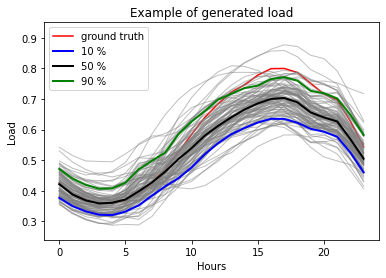

<Figure size 432x288 with 0 Axes>

In [69]:
n_s = 100
N_q = 99

# Quantiles are generated into an array of shape (n_day*24, N_q)
q_set = [i / (N_q + 1) for i in range(1, N_q + 1)]
quantiles = np.quantile(s_TEST_kappa.reshape((s_TEST_kappa.shape[0]*s_TEST_kappa.shape[1], s_TEST_kappa.shape[2])), q=q_set, axis=1).transpose()

point = random.randint(0, gt_kappa.shape[0] - 1)
print(point)
point = 19

plt.ylim(0.24,0.95)
plt.xlabel("Hours")
plt.ylabel("Load")
plt.title("Example of generated load")
plt.plot(gt_kappa[point], color = 'red', label = 'ground truth')
plt.plot(s_TEST_kappa[point, :, :], color='gray', linewidth=1, alpha=0.5)
plt.plot(quantiles[point * 24:(point+1)*24, 9], color='b', linewidth=2, label='10 %')
plt.plot(quantiles[point * 24:(point+1)*24, 49], color='k', linewidth=2, label='50 %')
plt.plot(quantiles[point * 24:(point+1)*24, 89], color='g', linewidth=2, label='90 %')
plt.legend()
plt.show()
plt.clf()

s_TEST_kappa = s_TEST_kappa.reshape(24*s_TEST_kappa.shape[0], n_s)

19


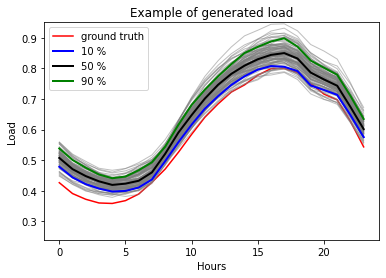

<Figure size 432x288 with 0 Axes>

In [70]:
n_s = 100
N_q = 99

# Quantiles are generated into an array of shape (n_day*24, N_q)
q_set = [i / (N_q + 1) for i in range(1, N_q + 1)]
quantiles = np.quantile(s_TEST_no_kappa.reshape((s_TEST_no_kappa.shape[0]*s_TEST_no_kappa.shape[1], s_TEST_no_kappa.shape[2])), q=q_set, axis=1).transpose()

point = random.randint(0, gt_no_kappa.shape[0] - 1)
print(point)
point = 19

plt.ylim(0.24,0.95)
plt.xlabel("Hours")
plt.ylabel("Load")
plt.title("Example of generated load")
plt.plot(gt_no_kappa[point], color = 'red', label = 'ground truth')
plt.plot(s_TEST_no_kappa[point, :, :], color='gray', linewidth=1, alpha=0.5)
plt.plot(quantiles[point * 24:(point+1)*24, 9], color='b', linewidth=2, label='10 %')
plt.plot(quantiles[point * 24:(point+1)*24, 49], color='k', linewidth=2, label='50 %')
plt.plot(quantiles[point * 24:(point+1)*24, 89], color='g', linewidth=2, label='90 %')
plt.legend()
plt.show()
plt.clf()

s_TEST_no_kappa = s_TEST_no_kappa.reshape(24*s_TEST_no_kappa.shape[0], n_s)


# Metrics


##### 1. Generate quantiles from scenarios ##### 
##### 2. PLF TEST & VS #####
PLF TEST 0.9736 VS 0.9736



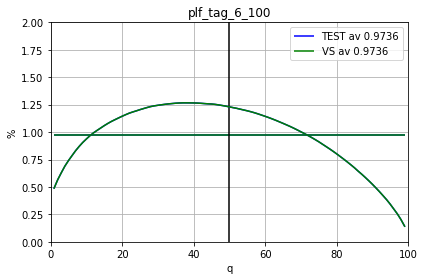

##### 3. Reliability diagram #####


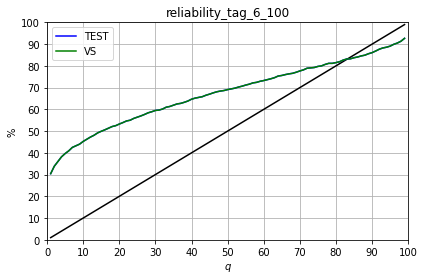

MAE TEST 18.72 VS 18.72
RMSE TEST 22.30 VS 22.30



In [19]:
plf_TEST_no_kappa, mae_TEST_no_kappa, crps_TEST_no_kappa = quantiles_and_evaluation(dir_path=dir_path, s_VS=s_TEST_no_kappa, s_TEST=s_TEST_no_kappa, N_q=N_q, df_y_VS=df_y_TEST, df_y_TEST=df_y_TEST, name='tag_6', ymax_plf=ymax_plf, ylim_crps=ylim_crps, tag=tag, nb_zones=nb_zones)

##### 1. Generate quantiles from scenarios ##### 
##### 2. PLF TEST & VS #####
PLF TEST 1.3985 VS 1.3985



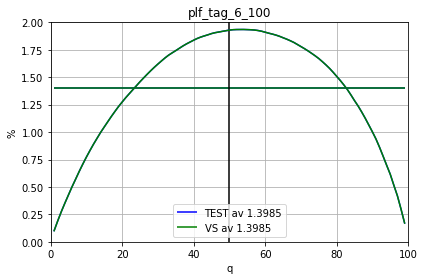

##### 3. Reliability diagram #####


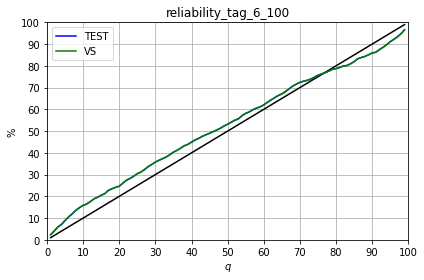

MAE TEST 3.69 VS 3.69
RMSE TEST 4.00 VS 4.00



In [20]:
plf_TEST_kappa, mae_TEST_kappa, crps_TEST_kappa = quantiles_and_evaluation(dir_path=dir_path, s_VS=s_TEST_kappa, s_TEST=s_TEST_kappa, N_q=N_q, df_y_VS=df_y_TEST, df_y_TEST=df_y_TEST, name='tag_6', ymax_plf=ymax_plf, ylim_crps=ylim_crps, tag=tag, nb_zones=nb_zones)

In [21]:
energy_no_kappa = np.mean(energy_score(s_TEST_no_kappa, gt_no_kappa))
variogram_no_kappa = np.mean(variogram_score(s_TEST_no_kappa, gt_no_kappa, 0.5))

energy_kappa = np.mean(energy_score(s_TEST_kappa, gt_kappa))
variogram_kappa = np.mean(variogram_score(s_TEST_kappa, gt_kappa, 0.5))


###########
(1200, 100)
(50, 24)
###########
(1200, 100)
(50, 24)
###########
(1200, 100)
(50, 24)
###########
(1200, 100)
(50, 24)


In [24]:
plf_TEST_no_kappa, crps_TEST_no_kappa*100, mae_TEST_no_kappa, energy_no_kappa*100, variogram_no_kappa

(0.973572512359497,
 1.9257571525987238,
 18.72222222222222,
 11.036830536124837,
 1.534954519404114)

In [25]:
plf_TEST_kappa, crps_TEST_kappa*100, mae_TEST_kappa, energy_kappa*100, variogram_kappa

(1.3985203961019381,
 2.7661550148442386,
 3.685185185185185,
 16.126839306127057,
 2.9671761714167544)

###########
(1200, 100)
(50, 24)


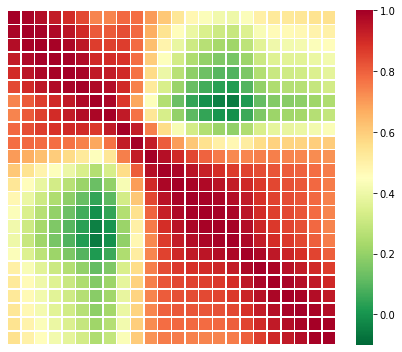

In [74]:
correlations, auto_corr = correlationScenarios(s_TEST_kappa, gt_kappa)
plt.figure(figsize=(6, 5))
sns_plot = sns.heatmap(auto_corr, cmap='RdYlGn_r', fmt=".1f", linewidths=0.5, xticklabels=False, yticklabels=False,
                        annot=False, vmin=-.1, vmax=1)
sns_plot.set_yticklabels(sns_plot.get_yticklabels(), rotation='horizontal')
plt.tight_layout()
plt.show()

###########
(1200, 100)
(50, 24)


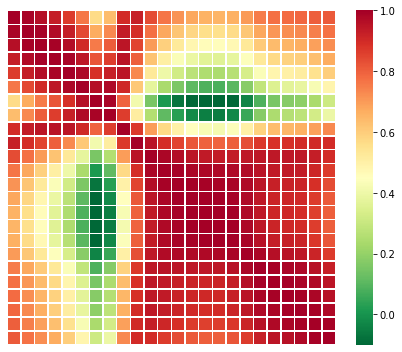

In [75]:
correlations, auto_corr = correlationScenarios(s_TEST_no_kappa, gt_no_kappa)
plt.figure(figsize=(6, 5))
sns_plot = sns.heatmap(auto_corr, cmap='RdYlGn_r', fmt=".1f", linewidths=0.5, xticklabels=False, yticklabels=False,
                        annot=False, vmin=-.1, vmax=1)
sns_plot.set_yticklabels(sns_plot.get_yticklabels(), rotation='horizontal')
plt.tight_layout()
plt.show()